# 📊 Análisis de gestiones y modelos de predicción  
Proyecto: **Gestión Inteligente**  

Este notebook documenta el análisis exploratorio de datos (EDA), la preparación de variables
y un resumen de los modelos usados en el dashboard de Streamlit:

- Modelo **NLP** para clasificar notas de gestiones (interesado / no_interesado)  
- Modelo **de predicción de pedidos** (Regresión Logística)  


## 1. Configuración e importación de librerías

In [ ]:
# Librerías básicas
import pandas as pd
import numpy as np

# Visualización
import matplotlib.pyplot as plt

# Opcional: estilos para gráficos
plt.style.use("seaborn-v0_8-darkgrid")

# Para procesamiento de texto (NLP) en este notebook
import re
import unicodedata
from collections import Counter
%matplotlib inline


## 2. Carga del dataset de gestiones

El dataset usado en el proyecto se encuentra en la carpeta `datos/` con el nombre
`gestiones.csv` (ajusta la ruta si es diferente en tu entorno).

In [3]:
# Ruta al archivo (ajusta si es necesario)
ruta_csv = "../datos/gestiones.csv"

df = pd.read_csv(ruta_csv)
print(df.shape)
df.head()

(1000000, 11)


,id_gestion,id_cliente,id_asesor,medio,resultado_asesor,fecha_hora,nota,pedido_generado,id_pedido,monto_pedido,producto_categoria
0,1,C000121959,A000000032,whatsapp,interesado,2025-11-10 20:05:34,Cliente solicitó que la información se enviara...,1,P000010989,2806.85,conectividad
1,2,C000146868,A000000110,whatsapp,no_interesado,2025-02-10 10:45:38,Recientemente compró algo similar a.,0,NaN,0.00,NaN
2,3,C000131933,A000000158,whatsapp,no_interesado,2025-11-01 20:14:25,Comentó que ya cuenta con un servicio similar ...,1,P000202762,6686.27,conectividad
3,4,C000103695,A000000105,whatsapp,no_interesado,2025-11-09 10:03:13,Cliente dijo que no ve necesario contratar.,0,NaN,0.00,NaN
4,5,C000119880,A000000181,llamada,no_interesado,2025-01-04 09:25:15,Cliente molesto por contacto recurrente.,0,NaN,0.00,NaN


## 3. Exploración inicial del dataset

In [4]:
# Información general
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id_gestion          1000000 non-null  int64  
 1   id_cliente          1000000 non-null  object 
 2   id_asesor           1000000 non-null  object 
 3   medio               1000000 non-null  object 
 4   resultado_asesor    1000000 non-null  object 
 5   fecha_hora          1000000 non-null  object 
 6   nota                1000000 non-null  object 
 7   pedido_generado     1000000 non-null  int64  
 8   id_pedido           400777 non-null   object 
 9   monto_pedido        1000000 non-null  float64
 10  producto_categoria  400777 non-null   object 
dtypes: float64(1), int64(2), object(8)
memory usage: 83.9+ MB


In [5]:
# Porcentaje de valores nulos por columna
df.isna().mean().sort_values(ascending=False)

id_pedido             0.599223
producto_categoria    0.599223
id_gestion            0.000000
id_cliente            0.000000
id_asesor             0.000000
medio                 0.000000
resultado_asesor      0.000000
fecha_hora            0.000000
nota                  0.000000
pedido_generado       0.000000
monto_pedido          0.000000
dtype: float64

In [6]:
# Estadísticos básicos de columnas numéricas
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id_gestion,1000000.0,500000.500000,288675.278932,1.0,250000.75,500000.5,750000.250,1000000.00
pedido_generado,1000000.0,0.400777,0.490056,0.0,0.00,0.0,1.000,1.00
monto_pedido,1000000.0,7051.940686,10718.423151,0.0,0.00,0.0,13269.465,34998.98


In [7]:
# Distribución de variables clave (ajusta nombres según tus columnas reales)
cols_categoricas = [
    "medio",              # llamada / whatsapp
    "resultado_asesor",   # interesado / no_interesado
    "producto_categoria", # conectividad / movilidad / hogar
]

for c in cols_categoricas:
    if c in df.columns:
        print(f"\nDistribución de: {c}")
        print(df[c].value_counts(dropna=False).head(10))


Distribución de: medio
medio
llamada     550276
whatsapp    449724
Name: count, dtype: int64

Distribución de: resultado_asesor
resultado_asesor
no_interesado    550594
interesado       449406
Name: count, dtype: int64

Distribución de: producto_categoria
producto_categoria
NaN             599223
conectividad    163000
movilidad       119327
hogar           118450
Name: count, dtype: int64


## 4. Variables temporales

En el proyecto se usan derivadas de la fecha/hora de la gestión:
- **hora**  
- **día de la semana**  
- **mes**  

Aquí generamos estas columnas a partir de la variable de fecha (ajusta el nombre de columna si es necesario).

In [8]:
# Intenta detectar un nombre de columna de fecha razonable
posibles_fechas = ["fecha_hora", "fecha_gestion", "fecha", "FECHA_HORA"]
col_fecha = None

for c in posibles_fechas:
    if c in df.columns:
        col_fecha = c
        break

print("Columna de fecha usada:", col_fecha)

if col_fecha is not None:
    df[col_fecha] = pd.to_datetime(df[col_fecha])
    df["anio"] = df[col_fecha].dt.year
    df["mes"] = df[col_fecha].dt.month
    df["dia_semana"] = df[col_fecha].dt.dayofweek  # 0 = lunes
    df["hora"] = df[col_fecha].dt.hour

Columna de fecha usada: fecha_hora


## 5. Desempeño general de gestiones y pedidos

In [9]:
# Asumimos que existe una columna binaria 'pedido_generado' (0/1)
# ajusta el nombre si es diferente en tus datos

col_pedido = None
for c in ["pedido_generado", "flag_pedido", "tiene_pedido"]:
    if c in df.columns:
        col_pedido = c
        break

print("Columna de pedido usada:", col_pedido)

if col_pedido is not None:
    total_gestiones = len(df)
    tasa_pedido = df[col_pedido].mean()
    print(f"Total de gestiones: {total_gestiones:,}")
    print(f"Porcentaje de gestiones que terminan en pedido: {tasa_pedido*100:.2f}%")

Columna de pedido usada: pedido_generado
Total de gestiones: 1,000,000
Porcentaje de gestiones que terminan en pedido: 40.08%


In [10]:
# Gestiones y pedidos por mes
if col_pedido is not None and "mes" in df.columns and "anio" in df.columns:
    resumen_mes = (
        df.groupby(["anio", "mes"])
        .agg(
            total_gestiones=("id_gestion", "count") if "id_gestion" in df.columns else (col_pedido, "size"),
            total_pedidos=(col_pedido, "sum"),
        )
        .reset_index()
    )
    resumen_mes["tasa_pedido"] = resumen_mes["total_pedidos"] / resumen_mes["total_gestiones"]
    resumen_mes

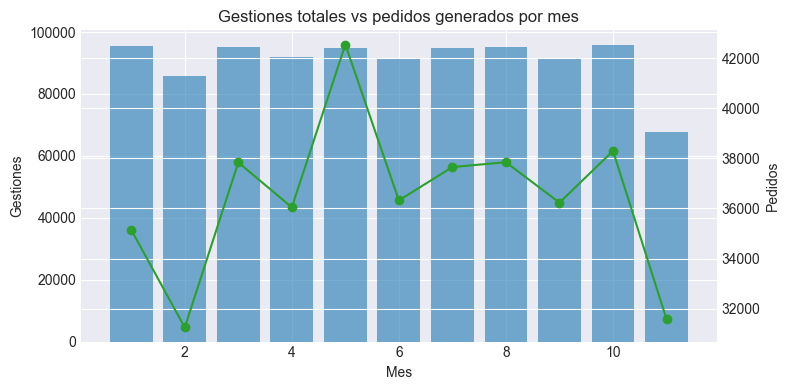

In [11]:
# Plot simple de gestiones vs pedidos por mes
if 'resumen_mes' in globals():
    fig, ax1 = plt.subplots(figsize=(8,4))
    ax1.bar(resumen_mes["mes"], resumen_mes["total_gestiones"], alpha=0.6, label="Gestiones")
    ax1.set_xlabel("Mes")
    ax1.set_ylabel("Gestiones")

    ax2 = ax1.twinx()
    ax2.plot(resumen_mes["mes"], resumen_mes["total_pedidos"], marker="o", label="Pedidos", color="tab:green")
    ax2.set_ylabel("Pedidos")

    plt.title("Gestiones totales vs pedidos generados por mes")
    fig.tight_layout()
    plt.show()

## 6. Comportamiento del interés del cliente

In [12]:
if "resultado_asesor" in df.columns and "mes" in df.columns and "anio" in df.columns:
    interes_mes = (
        df.groupby(["anio", "mes", "resultado_asesor"])
        .size()
        .reset_index(name="total")
    )
    interes_mes

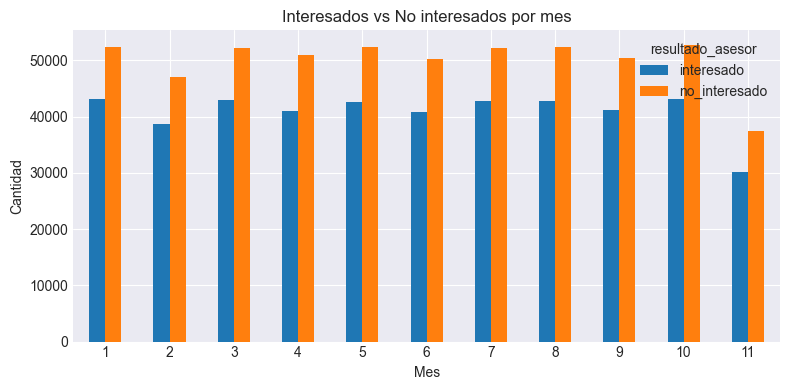

In [13]:
# Ejemplo de gráfico: interesados vs no_interesados por mes (si hay columnas disponibles)
if 'interes_mes' in globals():
    pivot_interes = interes_mes.pivot_table(
        index="mes", columns="resultado_asesor", values="total", aggfunc="sum"
    ).fillna(0)

    pivot_interes.plot(kind="bar", figsize=(8,4))
    plt.title("Interesados vs No interesados por mes")
    plt.xlabel("Mes")
    plt.ylabel("Cantidad")
    plt.xticks(rotation=0)
    plt.legend(title="resultado_asesor")
    plt.tight_layout()
    plt.show()

## 7. ¿Qué combinación de medio y categoría genera más pedidos?

In [14]:
if col_pedido is not None and "medio" in df.columns and "producto_categoria" in df.columns:
    tabla_medio_cat = (
        df.groupby(["medio", "producto_categoria"])
        .agg(
            pedidos=(col_pedido, "sum"),
            total_gestiones=(col_pedido, "size")
        )
        .reset_index()
    )
    tabla_medio_cat["tasa_pedido"] = tabla_medio_cat["pedidos"] / tabla_medio_cat["total_gestiones"]
    tabla_medio_cat.sort_values("pedidos", ascending=False)

## 8. Desempeño de asesores (Top & Bottom 10)

In [15]:
if col_pedido is not None and "id_asesor" in df.columns:
    asesores = (
        df.groupby("id_asesor")
        .agg(
            total_pedidos=(col_pedido, "sum"),
            total_gestiones=(col_pedido, "size")
        )
        .reset_index()
    )
    asesores["tasa_pedido"] = asesores["total_pedidos"] / asesores["total_gestiones"]

    top10 = asesores.sort_values("total_pedidos", ascending=False).head(10)
    bottom10 = asesores.sort_values("total_pedidos", ascending=True).head(10)

    print("TOP 10 asesores por pedidos:")
    display(top10)

    print("\nBOTTOM 10 asesores por pedidos:")
    display(bottom10)

TOP 10 asesores por pedidos:


,id_asesor,total_pedidos,total_gestiones,tasa_pedido
261,A000000262,1048,2003,0.523215
374,A000000375,1039,2078,0.500000
27,A000000028,1039,2024,0.513340
427,A000000428,1030,2047,0.503175
177,A000000178,1028,2007,0.512207
64,A000000065,1018,1964,0.518330
259,A000000260,1012,1973,0.512924
13,A000000014,1011,2068,0.488878
407,A000000408,1010,2010,0.502488
121,A000000122,1008,1948,0.517454



BOTTOM 10 asesores por pedidos:


,id_asesor,total_pedidos,total_gestiones,tasa_pedido
255,A000000256,539,1992,0.270582
135,A000000136,559,2021,0.276596
367,A000000368,564,2006,0.281157
383,A000000384,565,2007,0.281515
31,A000000032,572,2018,0.283449
16,A000000017,577,1993,0.289513
415,A000000416,581,1946,0.298561
156,A000000157,581,1951,0.297796
190,A000000191,583,1985,0.293703
356,A000000357,583,2020,0.288614


## 9. NLP: limpieza de notas de gestión

In [16]:
# Función de limpieza similar a la usada en el proyecto (limpiar_texto_udf)
def limpiar_texto(texto: str) -> str:
    if not isinstance(texto, str):
        return ""
    # Minúsculas
    texto = texto.lower()
    # Normalización de acentos
    texto = unicodedata.normalize("NFD", texto)
    texto = "".join(c for c in texto if unicodedata.category(c) != "Mn")
    # Eliminar caracteres no alfabéticos básicos
    texto = re.sub(r"[^a-zñáéíóúü0-9\s]", " ", texto)
    # Colapsar espacios múltiples
    texto = re.sub(r"\s+", " ", texto).strip()
    return texto

if "nota" in df.columns:
    df["nota_clean"] = df["nota"].apply(limpiar_texto)
    df[["nota", "nota_clean"]].head()

### 9.1 Palabras más frecuentes por clase (interesado vs no_interesado)

In [17]:
def top_palabras(df_local, etiqueta, n=30):
    subset = df_local[df_local["resultado_asesor"] == etiqueta]
    textos = " ".join(subset.get("nota_clean", ""))
    tokens = textos.split()
    contador = Counter(tokens)
    return pd.DataFrame(contador.most_common(n), columns=["palabra", "frecuencia"])

if "nota_clean" in df.columns and "resultado_asesor" in df.columns:
    top_int = top_palabras(df, "interesado", n=30)
    top_no = top_palabras(df, "no_interesado", n=30)

    print("Top palabras - interesado")
    display(top_int.head(10))

    print("\nTop palabras - no_interesado")
    display(top_no.head(10))

Top palabras - interesado


,palabra,frecuencia
0,que,265411
1,cliente,207249
2,pidio,170894
3,de,167078
4,la,162698
5,y,105598
6,por,92932
7,le,92684
8,conectividad,90886
9,mostro,79913



Top palabras - no_interesado


,palabra,frecuencia
0,no,398375
1,cliente,182258
2,que,163156
3,en,95410
4,desea,83012
5,la,80878
6,pidio,73492
7,dijo,65843
8,mas,64140
9,sobre,60070


## 10. Ejemplo de modelo NLP (versión sklearn para reproducibilidad local)

In [28]:

from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml import Pipeline
from pyspark.ml.feature import Tokenizer, StopWordsRemover, CountVectorizer, IDF, StringIndexer
from pyspark.ml.classification import LogisticRegression as SparkLogisticRegression
from pyspark.sql.types import StringType
from pyspark.sql.functions import udf
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [22]:

spark = SparkSession.builder.appName("modelo_pedidos_demo").getOrCreate()

df_spark = (
    spark.read.csv("../datos/gestiones.csv", header=True, inferSchema=True)
)

df_spark.printSchema()

# 1) Partimos del mismo df_spark ya cargado
df_texto = df_spark.select("nota", "resultado_asesor").dropna()

# 2) Limpiamos texto parecido a como lo haces en el proyecto
import unicodedata
import re

def limpiar_texto(texto: str) -> str:
    if texto is None:
        return ""
    # minúsculas
    texto = texto.lower()
    # normalizar acentos
    texto = unicodedata.normalize("NFKD", texto)
    texto = "".join([c for c in texto if not unicodedata.combining(c)])
    # quitar caracteres raros
    texto = re.sub(r"[^a-zñ0-9\s]", " ", texto)
    # colapsar espacios
    texto = re.sub(r"\s+", " ", texto).strip()
    return texto

limpiar_texto_udf = udf(limpiar_texto, StringType())

df_texto = df_texto.withColumn("nota_clean", limpiar_texto_udf("nota"))

# 3) Tomamos muestra de 50k
df_texto_sample = df_texto.limit(50000).cache()
df_texto_sample.show(5, truncate=False)

root
 |-- id_gestion: integer (nullable = true)
 |-- id_cliente: string (nullable = true)
 |-- id_asesor: string (nullable = true)
 |-- medio: string (nullable = true)
 |-- resultado_asesor: string (nullable = true)
 |-- fecha_hora: timestamp (nullable = true)
 |-- nota: string (nullable = true)
 |-- pedido_generado: integer (nullable = true)
 |-- id_pedido: string (nullable = true)
 |-- monto_pedido: double (nullable = true)
 |-- producto_categoria: string (nullable = true)



+-------------------------------------------------------------------------+----------------+------------------------------------------------------------------------+
|nota                                                                     |resultado_asesor|nota_clean                                                              |
+-------------------------------------------------------------------------+----------------+------------------------------------------------------------------------+
|Cliente solicitó que la información se enviara por whatsapp.             |interesado      |cliente solicito que la informacion se enviara por whatsapp             |
|Recientemente compró algo similar a.                                     |no_interesado   |recientemente compro algo similar a                                     |
|Comentó que ya cuenta con un servicio similar y no requiere conectividad.|no_interesado   |comento que ya cuenta con un servicio similar y no requiere conectividad|
|Cli

In [25]:
# 4) Definimos el pipeline NLP: tokenización + stopwords + TF-IDF + LR

# Indexar la etiqueta
label_indexer = StringIndexer(
    inputCol="resultado_asesor",
    outputCol="label"
)

# Tokenizador
tokenizer = Tokenizer(
    inputCol="nota_clean",
    outputCol="tokens"
)

# Stopwords en español + extras
stopwords_es = StopWordsRemover.loadDefaultStopWords("spanish")
# conservamos "no", "nunca", "ni"
stopwords_es = [w for w in stopwords_es if w not in ["no", "nunca", "ni"]]

stopwords_extra = [
    "dijo", "comento", "comentó", "menciono", "mencionó", "indico", "indicó",
    "pidio", "pidió", "mostro", "mostró", "solicito", "solicitó",
    "que", "de", "del", "la", "el", "al", "por", "para",
    "cliente", "asesor", "gestion", "gestión", "llamada", "contacto",
    "servicio", "servicios", "opciones", "opcion", "presupuesto",
    "producto", "productos", "paquete", "cuenta", "compra",
    "solucion", "detalles", "detalle", "informacion", "información",
    "más", "mas", "solo", "tambien", "también"
]

stopwords_es.extend(stopwords_extra)

remover = StopWordsRemover(
    inputCol="tokens",
    outputCol="tokens_clean",
    stopWords=stopwords_es
)

# CountVectorizer
vectorizer = CountVectorizer(
    inputCol="tokens_clean",
    outputCol="tf",
    minDF=5.0
)

# TF-IDF
idf = IDF(
    inputCol="tf",
    outputCol="features"
)

# Regresión Logística
lr_nlp = LogisticRegression(
    featuresCol="features",
    labelCol="label",
    maxIter=20
)

pipeline_nlp = Pipeline(stages=[
    label_indexer,
    tokenizer,
    remover,
    vectorizer,
    idf,
    lr_nlp
])

# 5) Train / test split
train_nlp, test_nlp = df_texto_sample.randomSplit([0.8, 0.2], seed=42)

modelo_nlp = pipeline_nlp.fit(train_nlp)
pred_nlp   = modelo_nlp.transform(test_nlp)

pred_nlp.select("nota", "resultado_asesor", "prediction", "probability").show(5, truncate=False)

25/11/23 17:56:06 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


+------------------------------------------------------------------------+----------------+----------+-----------------------------------------+
|nota                                                                    |resultado_asesor|prediction|probability                              |
+------------------------------------------------------------------------+----------------+----------+-----------------------------------------+
|Aunque aparece como interesado, dijo que no planea comprar conectividad.|interesado      |1.0       |[8.423874732357601E-6,0.9999915761252677]|
|Aunque aparece como interesado, dijo que no planea comprar conectividad.|interesado      |1.0       |[8.423874732357601E-6,0.9999915761252677]|
|Aunque aparece como interesado, dijo que no planea comprar conectividad.|interesado      |1.0       |[8.423874732357601E-6,0.9999915761252677]|
|Aunque aparece como interesado, dijo que no planea comprar conectividad.|interesado      |1.0       |[8.423874732357601E-6,0.9999

In [26]:
# 4) Definimos el pipeline NLP: tokenización + stopwords + TF-IDF + LR

# Indexar la etiqueta
label_indexer = StringIndexer(
    inputCol="resultado_asesor",
    outputCol="label"
)

# Tokenizador
tokenizer = Tokenizer(
    inputCol="nota_clean",
    outputCol="tokens"
)

# Stopwords en español + extras
stopwords_es = StopWordsRemover.loadDefaultStopWords("spanish")
# conservamos "no", "nunca", "ni"
stopwords_es = [w for w in stopwords_es if w not in ["no", "nunca", "ni"]]

stopwords_extra = [
    "dijo", "comento", "comentó", "menciono", "mencionó", "indico", "indicó",
    "pidio", "pidió", "mostro", "mostró", "solicito", "solicitó",
    "que", "de", "del", "la", "el", "al", "por", "para",
    "cliente", "asesor", "gestion", "gestión", "llamada", "contacto",
    "servicio", "servicios", "opciones", "opcion", "presupuesto",
    "producto", "productos", "paquete", "cuenta", "compra",
    "solucion", "detalles", "detalle", "informacion", "información",
    "más", "mas", "solo", "tambien", "también"
]

stopwords_es.extend(stopwords_extra)

remover = StopWordsRemover(
    inputCol="tokens",
    outputCol="tokens_clean",
    stopWords=stopwords_es
)

# CountVectorizer
vectorizer = CountVectorizer(
    inputCol="tokens_clean",
    outputCol="tf",
    minDF=5.0
)

# TF-IDF
idf = IDF(
    inputCol="tf",
    outputCol="features"
)

# Regresión Logística
lr_nlp = LogisticRegression(
    featuresCol="features",
    labelCol="label",
    maxIter=20
)

pipeline_nlp = Pipeline(stages=[
    label_indexer,
    tokenizer,
    remover,
    vectorizer,
    idf,
    lr_nlp
])

# 5) Train / test split
train_nlp, test_nlp = df_texto_sample.randomSplit([0.8, 0.2], seed=42)

modelo_nlp = pipeline_nlp.fit(train_nlp)
pred_nlp   = modelo_nlp.transform(test_nlp)

pred_nlp.select("nota", "resultado_asesor", "prediction", "probability").show(5, truncate=False)

+------------------------------------------------------------------------+----------------+----------+-----------------------------------------+
|nota                                                                    |resultado_asesor|prediction|probability                              |
+------------------------------------------------------------------------+----------------+----------+-----------------------------------------+
|Aunque aparece como interesado, dijo que no planea comprar conectividad.|interesado      |1.0       |[8.423874732357601E-6,0.9999915761252677]|
|Aunque aparece como interesado, dijo que no planea comprar conectividad.|interesado      |1.0       |[8.423874732357601E-6,0.9999915761252677]|
|Aunque aparece como interesado, dijo que no planea comprar conectividad.|interesado      |1.0       |[8.423874732357601E-6,0.9999915761252677]|
|Aunque aparece como interesado, dijo que no planea comprar conectividad.|interesado      |1.0       |[8.423874732357601E-6,0.9999

In [29]:
# 6) Métricas y matriz de confusión para el modelo NLP

eval_acc_nlp = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="accuracy"
)
eval_f1_nlp = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="f1"
)

acc_nlp = eval_acc_nlp.evaluate(pred_nlp)
f1_nlp  = eval_f1_nlp.evaluate(pred_nlp)

print(f"Accuracy (NLP): {acc_nlp:.4f}")
print(f"F1-score (NLP): {f1_nlp:.4f}")

conf_nlp = (
    pred_nlp
    .groupBy("label", "prediction")
    .count()
    .orderBy("label", "prediction")
)
conf_nlp.show()

Accuracy (NLP): 0.9308
F1-score (NLP): 0.9301
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  0.0|       0.0| 5455|
|  0.0|       1.0|   38|
|  1.0|       0.0|  658|
|  1.0|       1.0| 3901|
+-----+----------+-----+



## 11. Modelo de predicción de pedidos (plantilla sklearn)

In [39]:
# 1) Importamos librería 

from pyspark.sql import functions as F
from pyspark.ml.feature import OneHotEncoder,VectorAssembler
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [ ]:
# ============================================
# 11. Modelo de predicción de pedidos en PySpark
#    (usando una muestra de 50 000 registros)
# ============================================
# 2) Nos quedamos con las columnas que usa el modelo del proyecto
df_modelo = (
    df_spark
    .select("medio", "resultado_asesor", "fecha_hora", "pedido_generado")
    .withColumn("pedido_generado", F.col("pedido_generado").cast("int"))
    .withColumn("fecha_hora", F.to_timestamp("fecha_hora"))
    .dropna(subset=["medio", "resultado_asesor", "fecha_hora", "pedido_generado"])
)

# 3) Creamos variables de tiempo (hora, día de semana, mes)
df_modelo = (
    df_modelo
    .withColumn("hora", F.hour("fecha_hora"))
    .withColumn("dia_semana", F.dayofweek("fecha_hora"))  # 1–7
    .withColumn("mes", F.month("fecha_hora"))
)

# 4) Tomamos solo una muestra de 50k filas para el notebook
df_sample = df_modelo.limit(50000).cache()
df_sample.count(), df_sample.groupBy("pedido_generado").count().show()

+---------------+-----+
|pedido_generado|count|
+---------------+-----+
|              1|20209|
|              0|29791|
+---------------+-----+



25/11/23 18:00:27 WARN CacheManager: Asked to cache already cached data.


(50000, None)

In [37]:
# 5) Definimos el pipeline de features + Regresión Logística

# Indexamos variables categóricas
idx_medio = StringIndexer(inputCol="medio", outputCol="medio_idx", handleInvalid="keep")
idx_res  = StringIndexer(inputCol="resultado_asesor", outputCol="resultado_idx", handleInvalid="keep")

# One-hot encoding
ohc = OneHotEncoder(
    inputCols=["medio_idx", "resultado_idx"],
    outputCols=["medio_oh", "resultado_oh"]
)

# Ensamblamos el vector de características
assembler = VectorAssembler(
    inputCols=["medio_oh", "resultado_oh", "hora", "dia_semana", "mes"],
    outputCol="features"
)

# Modelo de regresión logística
lr = LogisticRegression(
    featuresCol="features",
    labelCol="pedido_generado",
    maxIter=20
)

pipeline_pedidos = Pipeline(stages=[idx_medio, idx_res, ohc, assembler, lr])

# 6) Train / test split
train_ped, test_ped = df_sample.randomSplit([0.8, 0.2], seed=42)

modelo_ped = pipeline_pedidos.fit(train_ped)
pred_ped   = modelo_ped.transform(test_ped)

pred_ped.select("medio", "resultado_asesor", "hora", "pedido_generado", "prediction", "probability").show(5, truncate=False)

+-------+----------------+----+---------------+----------+---------------------------------------+
|medio  |resultado_asesor|hora|pedido_generado|prediction|probability                            |
+-------+----------------+----+---------------+----------+---------------------------------------+
|llamada|interesado      |9   |0              |1.0       |[0.4363648384945631,0.5636351615054369]|
|llamada|interesado      |10  |0              |1.0       |[0.4322325081383328,0.5677674918616672]|
|llamada|interesado      |12  |0              |1.0       |[0.4239966247713504,0.5760033752286495]|
|llamada|interesado      |13  |0              |1.0       |[0.4198941643888972,0.5801058356111028]|
|llamada|interesado      |15  |0              |1.0       |[0.4117228952020983,0.5882771047979016]|
+-------+----------------+----+---------------+----------+---------------------------------------+
only showing top 5 rows


In [40]:
# 7) Métricas y matriz de confusión

evaluator_acc = MulticlassClassificationEvaluator(
    labelCol="pedido_generado",
    predictionCol="prediction",
    metricName="accuracy"
)
evaluator_f1 = MulticlassClassificationEvaluator(
    labelCol="pedido_generado",
    predictionCol="prediction",
    metricName="f1"
)
evaluator_auc = BinaryClassificationEvaluator(
    labelCol="pedido_generado",
    rawPredictionCol="rawPrediction",
    metricName="areaUnderROC"
)

acc = evaluator_acc.evaluate(pred_ped)
f1  = evaluator_f1.evaluate(pred_ped)
auc = evaluator_auc.evaluate(pred_ped)

print(f"Accuracy: {acc:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"AUC: {auc:.4f}")

# Matriz de confusión
conf_ped = (
    pred_ped
    .groupBy("pedido_generado", "prediction")
    .count()
    .orderBy("pedido_generado", "prediction")
)
conf_ped.show()

Accuracy: 0.7290
F1-score: 0.7307
AUC: 0.7462
+---------------+----------+-----+
|pedido_generado|prediction|count|
+---------------+----------+-----+
|              0|       0.0| 4422|
|              0|       1.0| 1570|
|              1|       0.0| 1154|
|              1|       1.0| 2906|
+---------------+----------+-----+



## 12. Conclusiones del análisis

- El dataset contiene información suficiente para analizar **gestiones comerciales**, pedidos y desempeño por asesor.  
- La tasa de conversión global (~40% en el dashboard) permite identificar **oportunidades de mejora**.  
- El comportamiento por mes y por categoría muestra que **no sólo importa cuántas gestiones se realizan, sino cómo y cuándo se hacen**.  
- El modelo NLP basado en TF-IDF + Regresión Logística logra una **alta capacidad para distinguir lenguaje de compra** (accuracy ~92% en el proyecto).  
- El modelo de predicción de pedidos permite estimar la probabilidad de éxito de una gestión en función del **medio, resultado del asesor y momento de contacto**, lo que habilita recomendaciones de horario y canal.

Este notebook sirve como soporte analítico y técnico del dashboard de Streamlit y del reporte ejecutivo.
